In [1]:
import numpy as np
import matplotlib.pyplot as plt
import solver.simple_hrl_solver as solver

from scipy.optimize import fsolve, curve_fit
import joblib as jl
import json
import glob
import matplotlib.cm as cm
import seaborn as sns
import os

In [2]:
def load_log(p):
    log =jl.load(p)
    args = json.load(open('/'.join(p.split('/')[:-1]) + '/args.json', 'r'))    
    return log, args

## First task

def rho1(tlist, VS0, VT0, N, T):
    rho_list=[]
    gamma = 1/np.pi/N/np.sqrt(2*np.pi)
    V = VS0[0]*VT0[0]
    T_const = np.power(2, T-2)
    for t in tlist:
        rho = -np.pi/2 + np.pi*np.power(gamma*(2-T)*V*t+T_const, 1/(2-T))
        rho_list.append(rho)
    return rho_list

def z_jump1(VS0, VT0, N,T):
    return np.sqrt(2*np.pi)*np.pi*N/(T-2)*np.power(2, T-2)/(VS0[0]*VT0[0])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


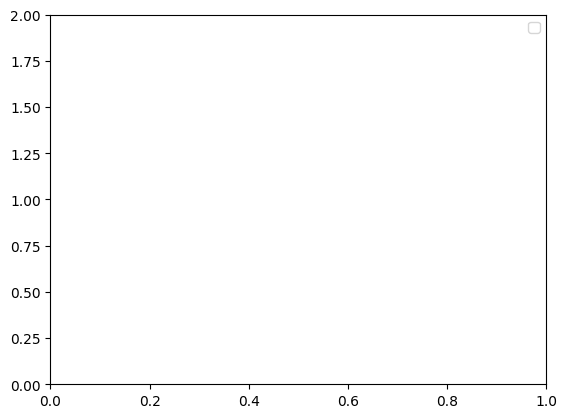

In [3]:
VS0 = [0.9,0.1]
VS0 /= np.linalg.norm(VS0)
VT0 = [1.0, 1.0]
VT0 /= np.linalg.norm(VT0)
N = 1000


plt.ylim(0, 2.0)
plt.legend()

In [4]:
def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """

    def proj(u, v):
        """
        Return projection of v to u
        """
        return np.dot(v, u) / np.dot(u, u) * u

    V = np.random.normal(loc=0., scale=1., size=(K, N))
    U = np.zeros_like(V)

    ## Initialise u1 to v1
    U[0] = V[0]

    ## Gram-schomidt process
    for k in range(1, K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)

    return V, U


def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT / np.linalg.norm(VT)
    a = np.random.normal(loc=0., scale=0.1, size=(dim))
    b = np.random.normal(loc=0., scale=0.1, size=(dim))
    a[0]=0.
    b[0]=1.
    h = (b - a) - np.dot((b - a), VT_norm) * VT_norm
    v = np.cos(angle) * VT_norm + np.sin(angle) * h / np.linalg.norm(h)

    return v


In [5]:
N = 1000
Ts = [6]
Ks = [2]
identical = False
v_norm = 0
w_angle = 1.55

lr_w = 1.
lr_wc = 1.
lr_v = 1.
nums_iter = np.array([0, 50000])
update_frequency = 100

sim_dic = {}
ode_dic = {}
for i in range(1):
    for seq_length in Ts:
        for num_tasks in Ks:
            _, WT_sim = gram_schmidt(N, num_tasks)
            WS_sim = WT_sim.copy()
            for i, w in enumerate(WS_sim):
                w_rot = control_VS(w, w_angle) * np.sqrt(N)
                WS_sim[i] = w_rot
            WS_ode = WS_sim.copy()
    
            VT_sim = VT0.copy()
            VS_sim = VS0.copy()
            VS_ode = VS_sim.copy()
            VT_ode = VT_sim.copy()
            WS_ode = WS_sim.copy()
            WT_ode = WT_sim.copy()

            ode_solver = solver.HRLODESolver(VS=VS_ode,
                                             VT=VT_ode,
                                             WS=WS_ode,
                                             WT=WT_ode,
                                             lr_ws=np.array([lr_w, lr_wc]),
                                             lr_v=lr_v,
                                             seq_length=seq_length,
                                             N=N,
                                             V_norm=v_norm)
            ode_solver.train(nums_iter, update_frequency=update_frequency)
            """
            sim = solver.simple_hrl_solver.CurriculumCompositionalTaskSimulator(
                input_dim=N,
                seq_len=seq_length,
                num_task=num_tasks,
                identical=False,
                WT=WT_sim,
                WS=WS_sim,
                VT=VT_sim,
                VS=VS_sim,
                V_norm=v_norm)

            sim.train(num_iter=nums_iter,
                      update_frequency=update_frequency,
                      lr={
                          'lr_w': lr_w,
                          'lr_wc': lr_wc,
                          'lr_vc': lr_v
                      })
            """
            if not (seq_length, num_tasks) in ode_dic.keys():
                
                ode_dic[(seq_length, num_tasks)] = [ode_solver]
            else:
                ode_dic[(seq_length, num_tasks)].append(ode_solver)

/tmp/ipykernel_3217445/2439665124.py:14: RuntimeWarning: invalid value encountered in power
  rho = -np.pi/2 + np.pi*np.power(gamma*(2-T)*V*t+T_const, 1/(2-T))


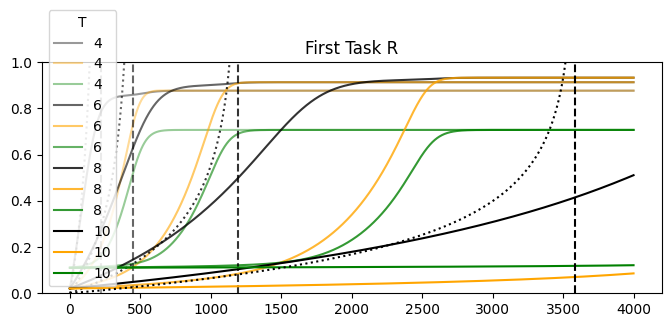

In [74]:
fig = plt.figure(figsize=(8,3))
ax1= plt.subplot(111)
for T in [4,6,8,10]:
    ode_res = ode_dic[T, 2][0]
    ax1.plot(ode_res.history['phase2']['R'][:,0,0], alpha = T*0.1, label = T, color = 'k')
    ax1.plot(ode_res.history['phase2']['R'][:,1,1], alpha = T*0.1, label = T, color = 'orange')
    ax1.plot(ode_res.history['phase2']['VS'][:,1], alpha = T*0.1, label = T, color = 'g')
    rho1_list=rho1(np.arange(0,400000,100), VS0, VT0, N, T)
    z1=z_jump1(VS0, VT0, N, T)
    ax1.plot(np.arange(0, 4000),rho1_list, c = 'k', alpha = 0.1*T, ls= 'dotted')
    ax1.vlines(z1//100, 0, 1.0, color= 'k', alpha = 0.1*T, ls = '--')
plt.ylim(0,1.0)
plt.title('First Task R')
plt.legend(title = 'T')
#plt.xscale('log')

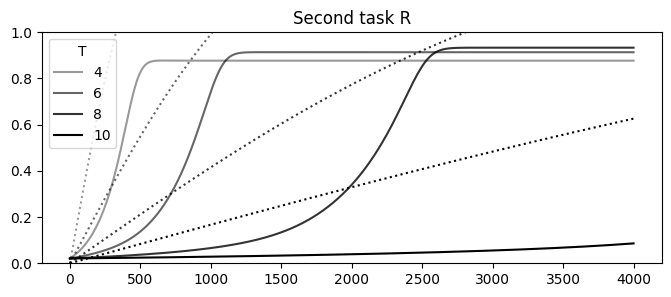

In [81]:
def rho_after1(tlist, VS0, VT0, N,T, k):
    rho_list = []
    V= VS0[k]*VT0[k]
    P_tilde = 1-1/np.pi*np.arccos(np.dot(VT0[:k], VT0[:k]))
    a=V/np.sqrt(2*np.pi)/N*np.power(P_tilde, T-1)
    b=1/N/T*np.power(VT0[k],2)*np.power(P_tilde, T)
    c = 1+b/a
    #rho_list = 
    
    
    for t in tlist:
        y = np.exp(2*a*np.sqrt(c)*t)
        rho_list.append(np.sqrt(c) * (y-1)/(1+y))
    
    return rho_list

fig = plt.figure(figsize=(8,3))
ax1= plt.subplot(111)
for T in [4,6,8,10]:
    ode_res = ode_dic[T, 2][0]
    ax1.plot(ode_res.history['phase2']['R'][:,1,1], alpha = T*0.1, label = T, color = 'k')
    rho1_list=rho_after1(np.arange(0,400000,100), VS0, VT0, N, T, k=1)
    #rho1_list=rho1(np.arange(0,400000,100), VS0, VT0, N, T)
    ax1.plot(np.arange(0, 4000),rho1_list, c = 'k', alpha = 0.1*T, ls= 'dotted')
plt.ylim(0,1.0)
plt.title('Second task R')
plt.legend(title = 'T')
#plt.xscale('log')

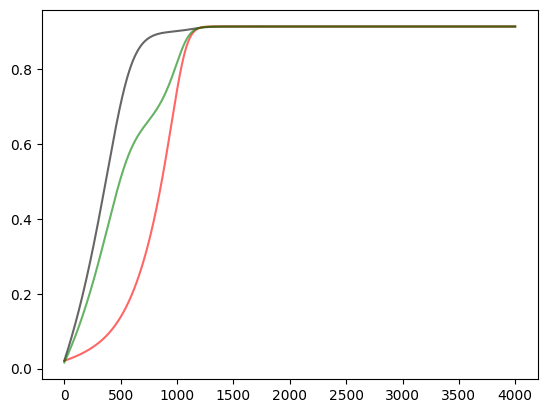

In [47]:

for T in Ts:
    ode_res = ode_dic[T, 2][0]
    plt.plot(ode_res.history['phase2']['R'][:,0,0], alpha = T*0.1, label = T, color = 'C0')
    plt.plot(ode_res.history['phase2']['R'][:,1,1], alpha = T*0.1, label = T, color = 'C1')
    plt.plot(, alpha = T*0.1, label = '--')


In [64]:
ode_res[0]